In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf


## Data

Data Source: General Social Survey

[Link to my project on GSS DataExplorer](https://gssdataexplorer.norc.org/projects/28298)
    
[Direct link to download data](https://gssdataexplorer.norc.org/extracts/20141/download)

The download is a gzipped tar file, which you can extract with

```
   tar -xzf gss_2000_2016.tar.gz
```

In [2]:
dct = thinkstats2.ReadStataDct('GSS.dct')
df = dct.ReadFixedWidth('GSS.dat')
print(df.shape)
df.head()

(24350, 35)


,year,god,compuse,webmob,emailmin,emailhr,usewww,wwwhr,wwwmin,intrhome,...,income,rincome,srcbelt,relig,denom,fund,relig16,denom16,fund16,sei10
0,2000,5,1,0,0,2,1,5,0,0,...,99,8,3,1,14,1,1,14,1,57.3
1,2000,6,1,0,0,0,2,-1,-1,0,...,8,8,3,1,18,1,2,0,2,38.8
2,2000,6,2,0,-1,-1,0,-1,-1,0,...,10,0,3,1,70,2,4,0,3,0.0
3,2000,0,1,0,0,3,1,2,0,0,...,12,0,3,10,0,9,1,14,1,89.9
4,2000,0,1,0,0,15,1,1,0,0,...,12,0,3,4,0,3,4,0,3,66.4


In [3]:
for colname in df.columns:
    print(colname, end='  ')

year  god  compuse  webmob  emailmin  emailhr  usewww  wwwhr  wwwmin  intrhome  parelkid  hispanic  sei  cohort  ballot  wtssall  conclerg  bible  sprel  id_  age  educ  sex  race  res16  income  rincome  srcbelt  relig  denom  fund  relig16  denom16  fund16  sei10  

## Cleaning and validation

In [4]:
def values(df, varname):
    """Values and counts in index order.
    
    df: DataFrame
    varname: strign column name
    
    returns: Series that maps from value to frequency
    """
    return df[varname].value_counts().sort_index()

In [5]:
values(df, 'year')

2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

In [6]:
cycle = df[df.year==2008]
values(cycle, 'wwwhr')

-1    2023
Name: wwwhr, dtype: int64

In [7]:
values(df, 'wwwhr')

-1      12726
 0       1202
 1       1517
 2       1304
 3        819
 4        593
 5        913
 6        358
 7        449
 8        294
 9         37
 10       946
 11        13
 12       201
 13        18
 14       231
 15       420
 16        35
 17        11
 18        22
 19         1
 20       559
 21        78
 22         7
 23         7
 24        43
 25       173
 26         2
 27         5
 28        45
        ...  
 49         2
 50        79
 55         4
 56         3
 60        48
 63         2
 64         1
 65         6
 66         1
 70        24
 72         6
 75         6
 80        20
 84         5
 85         1
 86         1
 90         4
 91         2
 98         1
 100       11
 112        2
 120        5
 122        1
 130        1
 132        1
 140        1
 168        2
 184        1
 998       54
 999      451
Name: wwwhr, dtype: int64

In [8]:
asked = df[df.wwwhr != -1].copy()
asked.shape

(11624, 35)

In [9]:
values(asked, 'year')

2000    1054
2002    1649
2004    1834
2006    2005
2010    1056
2012    1021
2014    1412
2016    1593
Name: year, dtype: int64

In [10]:
def fill_missing(df, varname, badvals=[98, 99]):
    """Fill missing data with random values.
    
    df: DataFrame
    varname: string column name
    badvals: list of values to be replaced
    """
    df[varname].replace(badvals, np.nan, inplace=True)
    null = df[varname].isnull()
    fill = np.random.choice(df[varname].dropna(), sum(null), replace=True)
    df.loc[null, varname] = fill
    return sum(null)

In [11]:
fill_missing(asked, 'relig')
values(asked, 'relig')

1.0     5512
2.0     2746
3.0      231
4.0     2242
5.0      144
6.0       99
7.0       54
8.0       22
9.0       63
10.0      48
11.0     381
12.0      13
13.0      69
Name: relig, dtype: int64

In [12]:
asked['has_relig'] = (df.relig != 4).astype(int)
values(asked, 'has_relig')

0    2234
1    9390
Name: has_relig, dtype: int64

In [13]:
fill_missing(asked, 'wwwhr', [998, 999])

505

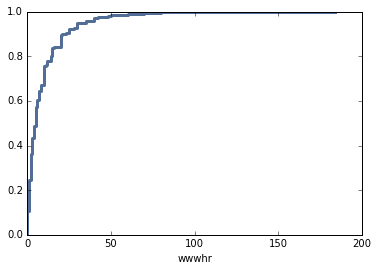

In [14]:
cdf = thinkstats2.Cdf(asked.wwwhr)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='wwwhr')

In [15]:
asked.wwwhr.describe()

count    11624.000000
mean         9.113730
std         13.044981
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        184.000000
Name: wwwhr, dtype: float64

## Basic model

In [16]:
results = smf.logit('has_relig ~ wwwhr', data=asked).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.484794
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              has_relig   No. Observations:                11624
Model:                          Logit   Df Residuals:                    11622
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Apr 2017   Pseudo R-squ.:                0.009372
Time:                        16:39:03   Log-Likelihood:                -5635.3
converged:                       True   LL-Null:                       -5688.6
                                        LLR p-value:                 5.377e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6020      0.029     55.133      0.000       1.545       1.659
wwwhr         -0.0167      0.002    -10.540      0.000      -0.020      -0.014
==============================================================================
"""

## Additional variables

In [17]:
asked['www50'] = asked.wwwhr >= 5
asked['www75'] = asked.wwwhr >= 10

In [18]:
fill_missing(asked, 'relig16')
values(asked, 'relig16')

1.0     6079
2.0     3787
3.0      248
4.0      931
5.0       54
6.0       70
7.0       60
8.0        6
9.0       76
10.0      57
11.0     232
12.0       7
13.0      17
Name: relig16, dtype: int64

In [19]:
asked['raised'] = asked.relig16 != 4
values(asked, 'raised')

False      931
True     10693
Name: raised, dtype: int64

In [20]:
values(asked, 'sex')

1    5271
2    6353
Name: sex, dtype: int64

In [21]:
values(asked, 'race')

1    9082
2    1462
3    1080
Name: race, dtype: int64

In [22]:
fill_missing(asked, 'hispanic')
values(asked, 'hispanic')

1.0     10361
2.0       744
3.0       147
4.0        52
5.0        41
6.0        22
7.0         6
8.0         9
9.0         2
10.0        7
11.0       17
15.0       28
20.0       20
21.0       13
22.0       24
23.0        9
24.0        9
25.0        3
30.0       68
31.0        1
35.0        3
40.0        4
41.0       11
45.0        3
46.0        4
47.0       10
50.0        6
Name: hispanic, dtype: int64

In [23]:
fill_missing(asked, 'educ')
values(asked, 'educ')

0.0       14
1.0        3
2.0       26
3.0        8
4.0       10
5.0       14
6.0       62
7.0       17
8.0       90
9.0      125
10.0     212
11.0     376
12.0    2663
13.0    1120
14.0    1770
15.0     750
16.0    2336
17.0     556
18.0     722
19.0     271
20.0     479
Name: educ, dtype: int64

In [24]:
fill_missing(asked, 'income')
values(asked, 'income')

1.0      124
2.0      119
3.0       67
4.0       50
5.0       66
6.0       77
7.0       61
8.0      142
9.0      497
10.0     505
11.0     649
12.0    8442
13.0     825
Name: income, dtype: int64

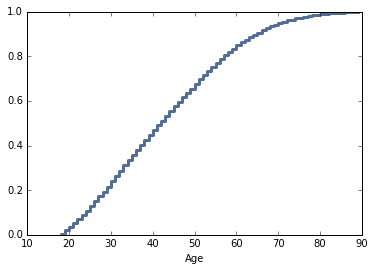

In [25]:
fill_missing(asked, 'age')
cdf = thinkstats2.Cdf(asked.age)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Age')

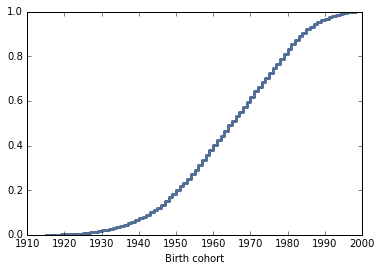

In [26]:
fill_missing(asked, 'cohort', [9999])
cdf = thinkstats2.Cdf(asked.cohort)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Birth cohort')

In [27]:
values(asked, 'year')

2000    1054
2002    1649
2004    1834
2006    2005
2010    1056
2012    1021
2014    1412
2016    1593
Name: year, dtype: int64

In [28]:
values(asked, 'srcbelt')

1     972
2    1547
3    1595
4    2049
5    4380
6    1081
Name: srcbelt, dtype: int64

In [29]:
asked['urban'] = asked.srcbelt <= 2
asked['rural'] = asked.srcbelt >= 5

In [30]:
fill_missing(asked, 'res16', [8, 9, 0])
values(asked, 'res16')

1.0    1202
2.0     800
3.0    3792
4.0    2098
5.0    1883
6.0    1849
Name: res16, dtype: int64

In [31]:
asked['farm'] = asked.res16 == 1
asked['country'] = asked.res16 == 2
asked['city'] = asked.res16 == 6

## Other dependent vars

In [32]:
fill_missing(asked, 'god', [8, 9])
values(asked, 'god')

0.0    4006
1.0     269
2.0     476
3.0     934
4.0     280
5.0    1298
6.0    4361
Name: god, dtype: int64

In [33]:
fill_missing(asked, 'bible', [8, 9, 0])
values(asked, 'bible')

1.0    3240
2.0    5718
3.0    2446
4.0     220
Name: bible, dtype: int64

In [34]:
fill_missing(asked, 'conclerg', [8, 9, 0])
values(asked, 'conclerg')

1.0    2274
2.0    6488
3.0    2862
Name: conclerg, dtype: int64

## Other classifiers

In [35]:
formula = ('has_relig ~ www50 + sex + educ + raised')
results = smf.logit(formula, data=asked).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.443303
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              has_relig   No. Observations:                11624
Model:                          Logit   Df Residuals:                    11619
Method:                           MLE   Df Model:                            4
Date:                Thu, 13 Apr 2017   Pseudo R-squ.:                 0.09416
Time:                        16:39:05   Log-Likelihood:                -5152.9
converged:                       True   LL-Null:                       -5688.6
                                        LLR p-value:                1.304e-230
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4055      0.167     -2.431      0.015      -0.732      -0.079
www50[T.True]     -0.4381      0.051     -8.591      0.000      -0.538      -0.338
raised[T.True]     2.1607      0.074     29.360      0.000       2.016       2.305
sex                0.4418      0.050      8.797      0.000       0.343       0.540
educ              -0.0341      0.009     -3.743      0.000      -0.052      -0.016
==================================================================================
"""

In [36]:
y = asked.has_relig
y.shape

(11624,)

In [37]:
X = asked[['www50', 'sex', 'educ', 'raised']]
X.shape

(11624, 4)

In [38]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [39]:
logreg.coef_

array([[-0.43809028,  0.44182493, -0.03413558,  2.16071839]])

In [40]:
logreg.intercept_

array([-0.40553838])

In [41]:
yfit = logreg.predict(X)

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(y, yfit)

0.82510323468685476

In [43]:
np.mean(y)

0.8078114246386786

In [44]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [45]:
logreg.fit(Xtrain, ytrain)
yfit = logreg.predict(Xtest)
accuracy_score(ytest, yfit)

0.8289745354439092

In [46]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y)
scores.mean()

0.82321019645721949

http://scikit-learn.org/stable/modules/ensemble.html

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, X, y)
scores.mean()

0.81108107537984131

In [48]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X, y)
scores.mean()

0.82329630678190979

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2)
scores = cross_val_score(clf, X, y)
scores.mean()

0.8216618981797591

In [50]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
scores = cross_val_score(clf, X, y)
scores.mean()

0.82183396339534032

Note: We don't really care about guessing who is affiliated or not.  What other accuracy metrics should we consider?